# Initialization

## Inport modules

In [1]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm import tqdm
from IPython.display import clear_output

from time import sleep, monotonic, time


import qcodes as qc
from qcodes import Parameter
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.measurements import Measurement

# sys.path.append('M:\\tnw\\ns\\qt\\2D Topo\\code\\qcodes')
sys.path.append('C:\\qcodes')
from sweeps import do1d, do2d, time_sweep, measure_until, do1d_until

import warnings
warnings.filterwarnings('ignore')

In [2]:
fridge_name = 'BF1'
# %run ..\..\..\..\..\code\qcodes\init_fridge.py {fridge_name}
%run C:\\qcodes\\init_fridge.py {fridge_name}

[keithley_24(Keithley2400)] Snapshot: Could not update parameter: volt
[keithley_24(Keithley2400)] Snapshot: Could not update parameter: curr
[keithley_24(Keithley2400)] Snapshot: Could not update parameter: resistance


Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04518052, firmware:1.7.7b) in 0.12s
Connected to: KEITHLEY INSTRUMENTS INC. 2440 (serial:1225508, firmware:C30   Mar 17 2006 09:29:29/A02  /B/A) in 0.03s


In [3]:
snapshot_of_station = station.snapshot()
pprint(snapshot_of_station)

{'components': {},
 'config': None,
 'instruments': {'keithley1': {'__class__': 'qcodes.instrument_drivers.tektronix.Keithley_6500.Keithley_6500',
                               'address': 'GPIB0::6::INSTR',
                               'functions': {},
                               'label': 'keithley1',
                               'name': 'keithley1',
                               'parameters': {'IDN': {'__class__': 'qcodes.parameters.parameter.Parameter',
                                                      'full_name': 'keithley1_IDN',
                                                      'instrument': 'qcodes.instrument_drivers.tektronix.Keithley_6500.Keithley_6500',
                                                      'instrument_name': 'keithley1',
                                                      'inter_delay': 0,
                                                      'label': 'IDN',
                                                      'name': 'IDN',
               

## DAC Kei 2440

### sensitive check

In [4]:
keithley_24.mode()

'VOLT'

In [5]:
keithley_24.output(1) # output on
keithley_24.rangev(10)
keithley_24.volt(0)
keithley_24.compliancei(100e-3)
# keithley_24.output(0) #output off
sleep(1)
v_read=keithley1.amplitude()
print(v_read)

0.1562


In [6]:
keithley_24.volt(0)
keithley_24.output(0) #output off

In [7]:
keithley_24.rangev(10)
keithley_24.rangev()

10.5

## TG 2400

In [8]:
keithley_19.output(1) # output on
keithley_19.rangev(22)
keithley_19.volt(0)
keithley_19.compliancei(100e-3)
# keithley_24.output(0) #output off
sleep(1)
v_read=keithley_2.amplitude()
print(v_read)

NameError: name 'keithley_19' is not defined

In [ ]:
keithley_19.volt(1)
keithley_19.output(0) #output off

In [ ]:
keithley_19.rangev(22)
keithley_19.rangev()

#  Database initialisation

In [9]:
reuse = True

%run ..\..\init_database.py {reuse}

Using existing database file:
c:\qcodes\personal_scripts\data\qcodes_personal_scripts_2024-05-17_01.db



# Scaled parameters

In [10]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters

In [11]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)
Vrange = Parameter('Vrange', label='voltage range', unit='', set_cmd=None, get_cmd=None)
TGrange = Parameter('TGrange', label='Top gate range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

# Irange_division = Parameter('Irange_division', 
#                             label='scaled current range', unit='', 
#                             set_cmd=None, get_cmd=lambda : 100 / Irange())

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1 / Irange())

Vrange_division = Parameter('Vrange_division', 
                            label='scaled voltage range', unit='', 
                            set_cmd=None, get_cmd=lambda : 100 / Vrange())

TGrange_division = Parameter('TGrange_division', 
                             label='scaled Top gate range', unit='', 
                             set_cmd=None, get_cmd=lambda : 1 / TGrange())

Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1000 / Irange())

Vrange_AC_division = Parameter('Vrange_AC_division', 
                               label='scaled voltage range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 1000 / Vrange())

Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)
station.add_component(Vrange)
station.add_component(TGrange)

station.add_component(Irange_division)
station.add_component(Vrange_division)
station.add_component(TGrange_division)

station.add_component(Irange_AC_division)
station.add_component(Vrange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
station.add_component(Gain_L2)

'Gain_L2'

## Parameters - update here during measuerements

In [36]:
Irange.set(1e-6) #Unit Amp V=IR, 1V= 1e-6 x 1MOhm=1e-7 x 10MOhm
Vrange.set(1) ## need to be sync with K213 range #Unit Volt
TGrange.set(1) #Unit Volt
Gain_K1.set(1e6)
Gain_K2.set(1e6)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
Gain_L2.set(Gain_K2())
#division parameters are updated automatically

In [ ]:
keithley_24.nplcv

## DC parameters

In [13]:

# appl_current = ScaledParameter(ivvi.dac1, division = Irange_division, name = 'appl_current', unit = 'A')
appl_current = ScaledParameter(keithley_24.volt, division = Irange_division, name = 'appl_current', unit = 'A')
# for K213
# appl_current = ScaledParameter(K213.voltage1, division = Irange_division, name = 'appl_current', unit = 'A')
appl_voltage = ScaledParameter(keithley_24.volt, division = Vrange_division, name = 'appl_voltage', unit = 'V')
#appl_TG = ScaledParameter(keithley_19.volt, division = TGrange_division, name = 'appl_TG', unit = 'V')

# meas_voltage_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_voltage_K1', unit = 'V')
meas_voltage_K2 = ScaledParameter(keithley1.amplitude, division = Gain_K2, name = 'meas_voltage_K2', unit = 'V')

meas_leakage = ScaledParameter(keithley1.amplitude, division = Gain_K2, name = 'meas_leakage', unit = 'A')

# meas_current_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_current_K1', unit = 'A')
meas_current_K2 = ScaledParameter(keithley1.amplitude, division = Gain_K2, name = 'meas_current_K2', unit = 'A')

station.add_component(appl_current)
station.add_component(appl_voltage)
#station.add_component(appl_TG)
# station.add_component(meas_voltage_K1)
station.add_component(meas_voltage_K2)
station.add_component(meas_leakage)
# station.add_component(meas_current_K1)
station.add_component(meas_current_K2)

'meas_current_K2'

In [14]:
keithley_24.output(0)
appl_current(0)
sleep(1)
# meas_voltage_K2()

##  AC parameters

In [ ]:
appl_current_AC = ScaledParameter(lockin_1.amplitude, division = Irange_AC_division, name = 'appl_current_AC', unit = 'A')
appl_voltage_AC = ScaledParameter(lockin_1.amplitude, division = Vrange_AC_division, name = 'appl_voltage_AC', unit = 'V')

station.add_component(appl_current_AC)
station.add_component(appl_voltage_AC)

meas_voltage_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_voltage_Lockin1', unit = 'V')
meas_current_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_current_Lockin1', unit = 'A')
meas_phase_AC_L1 = ScaledParameter(lockin_1.P, division = 1, name = 'meas_phase_Lockin1', unit = 'degree')


# meas_voltage_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_voltage_Lockin2', unit = 'V')
# meas_current_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_current_Lockin2', unit = 'A')
# meas_phase_AC_L2 = ScaledParameter(lockin_2.P, division = 1, name = 'meas_phase_Lockin1', unit = 'degree')

station.add_component(meas_voltage_AC_L1)
station.add_component(meas_current_AC_L1)
station.add_component(meas_phase_AC_L1)

# station.add_component(meas_voltage_AC_L2)
# station.add_component(meas_current_AC_L2)

meas_voltage_AC_L1_R = ScaledParameter(lockin_1.R, division = Gain_L1, name = 'meas_voltage_R_Lockin1', unit = 'V')
# meas_voltage_AC_L2_R = ScaledParameter(lockin_2.R, division = Gain_L2, name = 'meas_voltage_R_Lockin2', unit = 'V')

station.add_component(meas_voltage_AC_L1_R)
# station.add_component(meas_voltage_AC_L2_R)

In [ ]:
meas_voltage_AC_L1_P = ScaledParameter(lockin_1.P, division = 1, name = 'meas_voltage_Lockin1_P', unit = 'degree')
meas_current_AC_L1_P = ScaledParameter(lockin_1.P, division = 1, name = 'meas_current_Lockin1_P', unit = 'degree')

# meas_voltage_AC_L2_P = ScaledParameter(lockin_2.P, division = 1, name = 'meas_voltage_Lockin2_P', unit = 'degree')
# meas_current_AC_L2_P = ScaledParameter(lockin_2.P, division = 1, name = 'meas_current_Lockin2_P', unit = 'degree')

station.add_component(meas_voltage_AC_L1_P)
station.add_component(meas_current_AC_L1_P)

# station.add_component(meas_voltage_AC_L2_P)
# station.add_component(meas_current_AC_L2_P)

## Another useful example: magnet using dac (Janis)

>2231.2 G per A => 0.22312 T per A<br>
I source 10mA per V => 1e-5 A per 1mV<br>
result: 0.22312 T/A * 1e-5 A/mV

In [22]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K2']['meas_voltage_K2']
    current = dataset.get_parameter_data()['meas_voltage_K2']['appl_current']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

def get_R_from_IV_2(dataid):
    dataset = qc.load_by_id(dataid)

    current= dataset.get_parameter_data()['meas_current_K2']['meas_current_K2']
    voltage = dataset.get_parameter_data()['meas_current_K2']['appl_voltage']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]
def get_R_from_VI(dataid):
    dataset = qc.load_by_id(dataid)

    current= dataset.get_parameter_data()['meas_current_K2']['meas_current_K2']
    voltage = dataset.get_parameter_data()['meas_current_K2']['appl_voltage']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

def autosave_plot_by_id(run_id, save_path):
    fig, ax = plt.subplots()
    plot_by_id(run_id, axes=ax)
    plt.savefig(save_path)
    plt.close()

def IV(dataset=dataset,id=id):
    import plotly.graph_objs as go
    dataset = qc.load_by_id(id)
    R = get_R_from_IV(id)
    pandas_dataframe = dataset.to_pandas_dataframe()
    # Assuming 'pandas_dataframe' is your pandas DataFrame
    # Extract x and y data from the DataFrame
    x_data = pandas_dataframe.index.tolist()
    y_data = pandas_dataframe['meas_voltage_K2'].tolist()

    # Create a Plotly trace
    trace = go.Scatter(x=x_data, y=y_data, mode='lines', name='Voltage vs. Current')

    # Create layout
    layout = go.Layout(title=f'Run #{id} I vs. V,  R_fit={R:.4f} Ω',
                    xaxis=dict(title='Current'),
                    yaxis=dict(title='Voltage'),
                    width=600, height=600  )

    # Create the figure
    fig = go.Figure(data=[trace], layout=layout)

    # Plot the figure
    fig.show()

def IV_diff(dataset=dataset,id=id):
    import numpy as np
    import plotly.graph_objs as go
    from scipy.signal import find_peaks
    dataset = qc.load_by_id(id)
    # Convert the dataset to a pandas dataframe
    pandas_dataframe = dataset.to_pandas_dataframe()

    # Assuming 'pandas_dataframe' is your pandas DataFrame
    # Extract current and voltage data from the DataFrame
    current = pandas_dataframe.index.tolist()
    voltage = pandas_dataframe['meas_voltage_K2'].tolist()

    # Compute differential of voltage with respect to current
    differential_voltage = np.diff(voltage) / np.diff(current)

    # Since the differential will have one less data point, adjust the current data
    # to have the same length as the differential data
    current = current[:-1]

    # Find peaks in the differential signal
    peaks, _ = find_peaks(differential_voltage)

    # Extract peak current and peak differential voltage values
    peak_current = [current[i] for i in peaks]
    peak_voltage_diff = [differential_voltage[i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_voltage_diff)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_voltage_diff = [peak_voltage_diff[i] for i in top_two_peak_indices]

    # Calculate the center points of the top two peaks
    center_points = [(top_two_peak_current[i] + top_two_peak_current[i+1]) / 2 for i in range(len(top_two_peak_current) - 1)]

    # Calculate the difference between the top two biggest peaks
    peak_difference = abs(top_two_peak_current[0] - top_two_peak_current[1])

    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
        conversion_factor = 1e3
    elif peak_difference >= 1e-6:
        unit = "μA"
        conversion_factor = 1e6
    else:
        unit = "nA"
        conversion_factor = 1e9

    # Determine the appropriate unit for current
    if peak_difference >= 1e-3:
        unit = "mA"
    elif peak_difference >= 1e-6:
        unit = "μA"
    elif peak_difference >= 1e-9:
        unit = "nA"
    else:
        unit = "pA"

    # Create a Plotly trace for the differential
    trace_diff = go.Scatter(x=[c * conversion_factor for c in current], y=differential_voltage, mode='lines', name='d(Voltage)/d(Current)')
    # Add markers for the top two peaks
    trace_top_two_peaks = go.Scatter(x=[p * conversion_factor for p in top_two_peak_current], y=top_two_peak_voltage_diff, mode='markers', marker=dict(color='red'), name='Top Two Peaks')
    # Add markers for the center points
    trace_center_points = go.Scatter(x=center_points, y=[0]*len(center_points), mode='markers', marker=dict(color='blue', symbol='cross'), name='Center Points')

    # Create layout
    layout = go.Layout(title=f'Run #{id} I vs. dV/dI',
                    xaxis=dict(title=f'Current ({unit})'),
                    yaxis=dict(title='d(Voltage)/d(Current)'),
                    legend=dict(orientation="h", yanchor="top", y=1.10, xanchor="center", x=0.5),
                    width=600, height=600  
                    )

    # Create the figure
    fig = go.Figure(data=[trace_diff, trace_top_two_peaks, trace_center_points], layout=layout)

    # Add annotation for the current value of center points
    for i, center_point in enumerate(center_points):
        fig.add_annotation(
            x=center_point * conversion_factor,
            y=0, #0.4 * max(differential_voltage),
            text=f'Center Point: {center_point * conversion_factor:.3f}{unit} <br> Peak difference: {peak_difference*conversion_factor:.3f} {unit}',
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='black',
            ax=-100,
            ay=-200 - 30 * i
        )

    # Plot the figure
    fig.show()

def get_Mag(show=True):
    Mag_x = magnet_x.field()
    Mag_y = magnet_y.field()
    Mag_z = magnet_z.field()
    if show:
        print(f"Mag_x: {Mag_x*1e3:.6f} mT")
        print(f"Mag_y: {Mag_y*1e3:.6f} mT")
        print(f"Mag_z: {Mag_z*1e3:.6f} mT")
    else: 
        return Mag_x, Mag_y, Mag_z

In [ ]:
pip install plotly

In [20]:
dataset = qc.load_by_id(dataid)

In [21]:
dataset

results #4@c:\qcodes\personal_scripts\data\qcodes_personal_scripts_2024-05-17_01.db
-----------------------------------------------------------------------------------
appl_voltage - numeric
meas_current_K2 - numeric

In [ ]:
get_Mag()

In [48]:
dataset = qc.load_by_id(26)
df = dataset.to_pandas_dataframe().reset_index()
df

,appl_voltage,meas_current_K2
0,0.000100,-4.547788e-08
1,0.000099,-4.549441e-08
2,0.000098,-4.547736e-08
3,0.000097,-4.550107e-08
4,0.000096,-4.549369e-08
...,...,...
196,-0.000096,-4.560343e-08
197,-0.000097,-4.558865e-08
198,-0.000098,-4.562440e-08
199,-0.000099,-4.560537e-08


# Simple IVs

## IV

In [16]:
keithley_24.output(1)
keithley1.averaging_count(5)
keithley1.averaging_enabled(True)
keithley1.averaging_enabled(False)
keithley_24.output(0)

In [17]:
# Set current to 0
keithley_24.output(1)
appl_voltage()

0.0

There is (are) already experiment(s) with the name of V-I and sample name of MoS2_006_35_38 in the database.


Starting experimental run with id: 26. 


  0%|          | 0/201 [00:00<?, ?it/s]

Trying to mark a run completed that was already completed.
Trying to mark a run completed that was already completed.


ID:26
R = 555999.8559611385


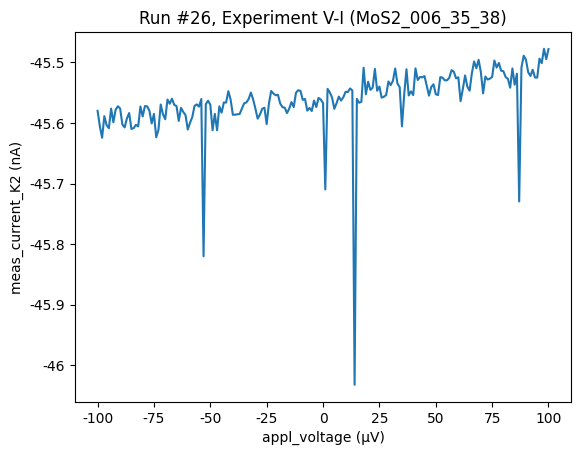

In [47]:
keithley_24.output(1)
V_range=-1e-4
appl_voltage(-V_range) #Limit:1e-5 Amp(1MOhms risistor),1e-6 Amp(10MOhms risistor)
sleep(2)
# station.snapshot(update=True);
exp = qc.new_experiment('V-I', sample_name='MoS2_006_35_38')
dataid = do1d(appl_voltage, -V_range ,V_range, 201, 0.01, meas_current_K2)

appl_current(0)
keithley_24.output(0)


plot_by_id(dataid)
save_path = r"C:\qcodes\personal_scripts\Yeep\Plot\006_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)
print(f"ID:{dataid}")
print(f"R = {get_R_from_IV_2(dataid)}")
dataset = qc.load_by_id(dataid)
# IV(id=dataid)
# IV_diff(id=dataid)

In [ ]:
for i in tqdm(range(1000)):
    keithley_24.output(1)
    I_range=1e-6
    appl_current(-I_range) #Limit:1e-5 Amp(1MOhms risistor),1e-6 Amp(10MOhms risistor)
    sleep(0.001)
    # station.snapshot(update=True);
    exp = qc.new_experiment('I-V', sample_name=f'103-03_J1_33-32-30-31_1M_F{i+1}')
    dataid = do1d(appl_current, -I_range ,I_range, 101, 0.0001, meas_voltage_K2)
    exp = qc.new_experiment('I-V', sample_name=f'103-03_J1_33-32-30-31_1M_B{i+1}')
    dataid = do1d(appl_current, I_range ,-I_range, 101, 0.0001, meas_voltage_K2)
    keithley_24.output(0)
    clear_output(True)

In [ ]:
get_Mag()

In [ ]:
SGS.off()

In [ ]:
SGS.power(0)

In [ ]:
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(True)

In [ ]:
for i in tqdm(range(21)):
    I_range = round(round(0.55 + 5*i * 1e-4, 6)* 1e-6, 10)  # Round to 3 decimal places
    print(I_range)


In [ ]:
for i in tqdm(range(21)):
    keithley_24.output(1)
    I_range = round(round(0.55 + 5*i * 1e-4, 6)* 1e-6, 10) 
    appl_current(-I_range) #Limit:1e-5 Amp(1MOhms risistor),1e-6 Amp(10MOhms risistor)
    sleep(2)
    # station.snapshot(update=True);
    exp = qc.new_experiment('I-V', sample_name=f'103-04_J1_24-25-05-04(06-07G)_1M_By@0mT_{-I_range}_201')
    dataid = do1d(appl_current, -I_range ,I_range, 201, 0.00001, meas_voltage_K2)

    appl_current(0)
    keithley_24.output(0)


    plot_by_id(dataid)
    save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
    autosave_plot_by_id(dataid, save_path)
    print(f"ID:{dataid}")
    print(f"R = {get_R_from_IV_2(dataid)}")
    dataset = qc.load_by_id(dataid)
    IV(id=dataid)
    IV_diff(id=dataid)

In [ ]:
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(True)

In [ ]:
keithley_24.output(1)
I_range = -6e-6
appl_current(-I_range) #Limit:1e-5 Amp(1MOhms risistor),1e-6 Amp(10MOhms risistor)
sleep(2)
# station.snapshot(update=True);
exp = qc.new_experiment('I-V', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_By@0.1mT{-I_range}')
dataid = do1d(appl_current, -I_range  ,I_range , 2601, 0.00001, meas_voltage_K2)
appl_current(0)
keithley_24.output(0)
plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)
print(f"R = {get_R_from_IV_2(dataid)}")
dataset = qc.load_by_id(dataid)

In [ ]:
keithley_24.output(1)
I_range = 6e-6
appl_current(-I_range) #Limit:1e-5 Amp(1MOhms risistor),1e-6 Amp(10MOhms risistor)
sleep(2)
# station.snapshot(update=True);
exp = qc.new_experiment('I-V', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_By@0.1mT{-I_range}')
dataid = do1d(appl_current, -I_range  ,I_range , 2601, 0.00001, meas_voltage_K2)
appl_current(0)
keithley_24.output(0)
plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)
print(f"ID:{dataid}")
print(f"R = {get_R_from_IV_2(dataid)}")
dataset = qc.load_by_id(dataid)
# IV(id=dataid)
# IV_diff(id=dataid)

In [ ]:
25-05-06-07(04-24G)


In [ ]:
keithley_24.output(1)
I_range=-7e-6
appl_current(-I_range) #Limit:1e-5 Amp(1MOhms risistor),1e-6 Amp(10MOhms risistor)
sleep(2)
# station.snapshot(update=True);
exp = qc.new_experiment('I-V', sample_name='103-03_J2_32-30-26-27_1M_By@0mT')
dataid = do1d(appl_current, -I_range ,I_range, 1401, 0.0001, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)


plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)
print(f"ID:{dataid}")
print(f"R = {get_R_from_IV_2(dataid)}")
dataset = qc.load_by_id(dataid)
IV(id=dataid)
IV_diff(id=dataid)

In [ ]:
keithley_24.output(1)
I_range=7e-6
appl_current(-I_range) #Limit:1e-5 Amp(1MOhms risistor),1e-6 Amp(10MOhms risistor)
sleep(2)
# station.snapshot(update=True);
exp = qc.new_experiment('I-V', sample_name='103-03_J2_32-30-26-27_1M_By@0mT')
dataid = do1d(appl_current, -I_range ,I_range, 1401, 0.0001, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)


plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)
print(f"ID:{dataid}")
print(f"R = {get_R_from_IV_2(dataid)}")
dataset = qc.load_by_id(dataid)
IV(id=dataid)
IV_diff(id=dataid)

In [ ]:
# Set current to 0
keithley_24.output(0)
appl_current(0e-6)

In [ ]:
keithley_24.output(1)
appl_current(0.1e-7)

In [ ]:
runid=6
print(get_R_from_IV_2(runid))

## 加TG (1D)

In [ ]:
keithley_19.output(1)
appl_TG(0)

In [ ]:
keithley_19.output(1)
keithley_24.output(1)
appl_TG(-50)
sleep(3)
appl_current(-1.5e-8)
sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV', sample_name='TG21')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do1d(appl_current, -1.5e-8 ,1.5e-8, 101, 0.05, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

keithley_19.output(0)
keithley_24.output(0)
appl_current(0)
plot_by_id(dataid)
#print(get_R_from_IV(dataid))
# print(get_R_from_IV_2(dataid))


## 歸零


In [ ]:
#keithley_19.output(1)
keithley_24.output(1)

appl_current(0)
sleep(1)
#appl_TG(0)
sleep(5)

#keithley_19.output(0)
keithley_24.output(0)

# Magnetic field

## IV vs Bx

In [ ]:
keithley_24.rangev()

In [ ]:
keithley_24.volt(0)
keithley_24.output(1) #output off
sleep(1)
appl_current(1.5e-7)
sleep(2)
meas_voltage_K2()

In [ ]:
sleep(120)

In [ ]:
def get_Mag(show=True):
    Mag_x = magnet_x.field()
    Mag_y = magnet_y.field()
    Mag_z = magnet_z.field()
    if show:
        print(f"Mag_x: {Mag_x*1e3:.6f} mT")
        print(f"Mag_y: {Mag_y*1e3:.6f} mT")
        print(f"Mag_z: {Mag_z*1e3:.6f} mT")
    else: 
        return Mag_x, Mag_y, Mag_z
get_Mag()

In [ ]:
get_Mag()

In [ ]:
magnet_y.field()

In [ ]:
for i in tqdm(range(23), desc="First loop"):
    value = (25 - i) * 1e-3 
    value = float(f"{value:.10f}")
    print(value)

In [ ]:
from tqdm import tqdm
import time

from IPython.display import clear_output
# First loop
for i in tqdm(range(6), desc="First loop"):
    Mag_x = magnet_x.field()
    value = (15 + i) * 1e-3
    value = float(f"{value:.10f}")
    magnet_x.field(value)
    print(f"magnet_x is {Mag_x:.8f} T")
    time.sleep(15)
    clear_output(True)

# Pause for 30 seconds
time.sleep(60)

# Second loop
for i in tqdm(range(23), desc="First loop"):
    Mag_x = magnet_x.field()
    value = (25 - i) * 1e-3 
    value = float(f"{value:.10f}")
    magnet_x.field(value)
    print(f"magnet_x is {Mag_x:.8f} T")
    time.sleep(15)
    clear_output(True)

# Pause for 180 seconds
time.sleep(300)

In [ ]:
magnet_x.field(-20)

In [ ]:
Mag = -20e-3
I_range=2.5e-6
keithley_24.output(1)
sleep(2)
magnet_x.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs Bx', sample_name=f'103-06_J2_12-13-18-19_1M_Bx_{direction}_By@0mT')

dataid = do2d(magnet_x.field, Mag, -Mag, 76 , 0.7, appl_current, -I_range ,I_range, 101, 0.01, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
keithley_24.output(1)
sleep(2)
Mag = 10e-3
I_range=2.5e-5

magnet_x.field(Mag)
sleep(30)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);

exp = qc.new_experiment('IV vs Bx', sample_name=f'094-20IV_Bx_16-17-19-18_10M_{direction}')

dataid = do2d(magnet_x.field, Mag, -Mag, 101 , 1.5, appl_current, -I_range ,I_range, 101, 0.05, meas_voltage_K2)#M:I Delay time 10:1


appl_current(0)
keithley_24.output(0)
# magnet_x.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
set_magnetic_field_stepwise(magnet=magnet_x, current_field=-40e-3, target_field=-18e-3, step_size=1e-3, delay=2.5)

In [ ]:
def set_magnetic_field_stepwise(magnet=magnet_x, current_field=0, target_field=-10e-3, step_size=1e-3, delay=2.5):
    
    """Set the magnetic field with anti-hysteresis mechanism witch will go to target magnetic field +/- 5mT, 
    if the target magnetic field is greater/less than the current magnetic field, 
    then slowly ramp back the magnetic field to the target magnetic field

    Args:
        magnet (_type_, optional): magnet_x,magnet_y,magnet_z. Defaults to magnet_x.
        current_field (int, optional): _description_. Defaults to 0 T.
        target_field (_type_, optional): _description_. Defaults to -10e-3 T.
        step_size (_type_, optional): _description_. Defaults to 1e-3 T.
        delay (float, optional): _description_. Defaults to 2 sec.
    
    """
    
    from tqdm.notebook import tqdm
    import math
    # Calculate total steps for tqdm progress bar
    total_steps = math.ceil(abs((target_field - current_field) / step_size)) * 2
    progress_bar = tqdm(total=total_steps)

    # Determine the intermediate target field
    intermediate_target_field = target_field + 5e-3 if target_field > current_field else target_field - 5e-3
    # Slowly ramp the magnetic field to the intermediate target field
    while abs(intermediate_target_field - current_field) > step_size:
        if intermediate_target_field > current_field:
            current_field += step_size
            magnet.field(current_field)
        else:
            current_field -= step_size
            magnet.field(current_field)
        time.sleep(delay)
        progress_bar.update(1)  # Update progress bar
    # Slowly ramp back the magnetic field to the target_field
    while abs(target_field - current_field) > step_size:
        if target_field > current_field:
            current_field += step_size
            magnet.field(current_field)
        else:
            current_field -= step_size
            magnet.field(current_field)
        time.sleep(delay)
        progress_bar.update(1)  # Update progress bar
    magnet.field(target_field)
    progress_bar.n = total_steps  # Set progress bar to 100%
    progress_bar.refresh()  # Refresh the progress bar to show the update
    progress_bar.close()  # Close progress bar when done

In [ ]:
for i in range(6):
    magnet_x.field((-10-i)*1e-3)
    sleep(4)
sleep(10)

for i in range(16):
    magnet_x.field((15+i)*1e-3)
    sleep(4)
sleep(10)

In [ ]:
for i in range(25):
    print(-24+i)

In [ ]:
magnet_x.field(-19e-3)
sleep(10)
#magnet_x.field(e-3)
#sleep(10)
#magnet_x.field(12.8e-3)
#sleep(10)

## IV vs By

In [ ]:
get_Mag()

In [ ]:
magnet_y.field(0e-3)

In [ ]:
for i in tqdm(range(21), desc="2nd loop"):
    
    value = (-10 + i*0.5) * 1e-3 
    value = float(f"{value:.10f}")
    magnet_y.field(value)
    get_Mag()
    time.sleep(15)
    clear_output(True)

In [ ]:

# First loop
for i in tqdm(range(11), desc="First loop"):
    
    value = (5 +i) * 1e-3
    value = float(f"{value:.10f}")
    magnet_y.field(value)
    get_Mag()
    time.sleep(15)
    clear_output(True)

# Pause for 30 seconds
time.sleep(60)

# Second loop
for i in tqdm(range(11), desc="2nd loop"):
    
    value = (-10 + i) * 1e-3 
    value = float(f"{value:.10f}")
    magnet_y.field(value)
    get_Mag()
    time.sleep(15)
    clear_output(True)
# Pause for 180 seconds
time.sleep(300)

In [ ]:
magnet_y.field()

In [ ]:
Mag =5e-3
I_range=0.6e-6
keithley_24.output(1)
sleep(2)
magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs By', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_By_{direction}_{-I_range}')

dataid = do2d(magnet_y.field, Mag, -Mag, 201 , 0.5, appl_current, -I_range ,I_range,  201, 0.0001, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
Mag =-5e-3
I_range=5e-6
keithley_24.output(1)
sleep(2)
magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs By', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_By_{direction}_{-I_range}')

dataid = do2d(magnet_y.field, Mag, -Mag, 201 , 0.5, appl_current, -I_range ,I_range,  201, 0.0001, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
32-

In [ ]:

# First loop
for i in tqdm(range(6), desc="First loop"):
    Mag_x = magnet_y.field()
    value = (1.5 +i) * 1e-3
    value = float(f"{value:.10f}")
    magnet_y.field(value)
    print(f"magnet_y is {Mag_x:.8f} T")
    time.sleep(15)
    clear_output(True)

# Pause for 30 seconds
time.sleep(60)

# Second loop
for i in tqdm(range(6), desc="2nd loop"):
    Mag_x = magnet_y.field()
    value = (6.5 - i) * 1e-3 
    value = float(f"{value:.10f}")
    magnet_y.field(value)
    print(f"magnet_y is {Mag_x:.8f} T")
    time.sleep(15)
    clear_output(True)

# Pause for 180 seconds
time.sleep(300)

In [ ]:
Mag = 1.5e-3
I_range=2.5e-6
keithley_24.output(1)
sleep(2)
magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs By', sample_name=f'103-06_J2_12-13-18-19_1M_By_{direction}_Bx@3mT')

dataid = do2d(magnet_y.field, Mag, -Mag, 1001 , 0.4, appl_current, -I_range ,I_range, 151, 0.01, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
Mag()

In [ ]:
Mag = 1.5e-3
I_range=1e-6
keithley_24.output(1)
sleep(2)
magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs By', sample_name=f'103-01_J1_21-20-23-22_1M_By_{direction}_Bx@0mT')

dataid = do2d(magnet_y.field, Mag, -Mag, 151 , 0.9, appl_current, -I_range ,I_range, 201, 0.01, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
from tqdm import tqdm
import time

# First loop
for i in tqdm(range(6), desc="First loop"):
    value = (1.5 + i) * 1e-3 
    magnet_y.field(value)
    print(f"magnet_y is {value:.8f} T")
    time.sleep(10)

# Pause for 30 seconds
time.sleep(30)

# Second loop
for i in tqdm(range(8), desc="First loop"):
    value = (7 - i) * 1e-3 
    magnet_y.field(value)
    print(f"magnet_y is {value:.8f} T")
    time.sleep(10)

# Pause for 180 seconds
time.sleep(300)


In [ ]:
def combined_loop(start=0, end=5 ):
  for i in tqdm(range((end-start)+6), desc="First loop"):
    value = start + i
    print(f"{value* 1e-3:.5f}")

  for i in tqdm(range(6), desc="Second loop"):
    value = end+5 - i
    print(f"{value* 1e-3:.5f}")

combined_loop()


In [ ]:
Mag = 3e-3
I_range=1e-6
keithley_24.output(1)
sleep(2)
magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs By', sample_name=f'103-04_J2_04-05-06-07_1M_By_{direction}_Bx@0mT')

dataid = do2d(magnet_y.field, Mag, -Mag, 101 , 1.5, appl_current, -I_range ,I_range, 101, 0.01, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
from tqdm import tqdm
import time

# First loop
for i in tqdm(range(6), desc="First loop"):
    magnet_y.field((-3 - i) * 1e-3)
    time.sleep(15)

# Pause for 30 seconds
time.sleep(30)

# Second loop
for i in tqdm(range(7), desc="Second loop"):
    magnet_y.field((-8 + i) * 1e-3)
    time.sleep(15)

# Pause for 180 seconds
time.sleep(300)

In [ ]:
magnet_y.field(-1.5e-3)
print("By at -1.5 mT")

In [ ]:
Mag = -3e-3
I_range=1e-6
keithley_24.output(1)
sleep(2)
magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs By', sample_name=f'103-04_J2_04-05-06-07_1M_By_{direction}_Bx@0mT')

dataid = do2d(magnet_y.field, Mag, -Mag, 501 , 1, appl_current, -I_range ,I_range, 251, 0.01, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
from tqdm import tqdm
import time

# First loop
for i in tqdm(range(6), desc="First loop"):
    magnet_y.field((3 + i) * 1e-3)
    time.sleep(10)

# Pause for 30 seconds
time.sleep(30)

# Second loop
for i in tqdm(range(6), desc="Second loop"):
    magnet_y.field((8 - i) * 1e-3)
    time.sleep(10)

# Pause for 180 seconds
time.sleep(300)

In [ ]:
Mag = 3e-3
I_range=1e-6
keithley_24.output(1)
sleep(2)
magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);
exp = qc.new_experiment('IV vs By', sample_name=f'103-04_J2_04-05-06-07_1M_By_{direction}_Bx@0mT')

dataid = do2d(magnet_y.field, Mag, -Mag, 501 , 1, appl_current, -I_range ,I_range, 251, 0.01, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
magnet_y.field(5e-3)

In [ ]:
for i in range(9):
    magnet_y.field((0+i)*1e-3)
    sleep(4)
sleep(10)

for i in range(6):
    magnet_y.field((8-i)*1e-3)
    sleep(4)

sleep(60)
# magnet_y.field(21.5e-3)
sleep(60)
#magnet_y.field(0.48e-3)
#sleep(5)

In [ ]:
for i in range(4):
    print(8-i)

In [ ]:
keithley_24.output(1)
sleep(2)
Mag = -40e-3
I_range=2e-8

magnet_y.field(Mag)
sleep(10)
appl_current(-I_range)
sleep(3)
direction = 'backward' if Mag > 0 else 'forward'


# station.snapshot(update=True);

exp = qc.new_experiment('IV vs By', sample_name=f'094-20IV_By_16-17-19-18_10M_{direction}_Bx@-18.5mT')

dataid = do2d(magnet_y.field, Mag, -Mag, 601 , 2, appl_current, -I_range ,I_range, 201, 0.1, meas_voltage_K2)


appl_current(0)
keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)
autosave_plot_by_id(dataid, save_path)

In [ ]:
for i in range(24):
    print(45-i)

## IV vs Bz

In [ ]:
keithley_24.output(1)
sleep(2)
magnet_z.field(-80e-3)
sleep(60)
appl_current(-2e-7)
sleep(5)

# station.snapshot(update=True);

exp = qc.new_experiment('IV vs Bz', sample_name='IV_Bz_33_32_30_31_10M_forward')

dataid = do2d(magnet_z.field,-80e-3,80e-3, 71 , 20, appl_current, -2e-7 ,2e-7, 101, 0.05, meas_voltage_K2)

appl_current(0)

keithley_24.output(0)
# magnet_y.field(0)

plot_by_id(dataid)

In [ ]:
#magnet_z.field(20e-3)
#sleep(5)
magnet_z.field(-6.1e-3)
sleep(5)

## IV w/ Bx

In [ ]:
keithley_24.output(1)
sleep(2)
magnet_x.field(0.23e-3)
appl_current(-0.5e-6)
sleep(10)

# station.snapshot(update=True);
exp = qc.new_experiment('I vs V', sample_name='IV_w/_Bx')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do1d(appl_current, -0.5e-6 ,0.5e-6, 101, 0.05, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
#print(get_R_from_IV_2(dataid))

keithley_24.output(0)

## IV w/ By

In [ ]:
keithley_24.output(1)
keithley_2.averaging_count(30)
#keithley_2.averaging_enabled(False)

sleep(2)
magnet_y.field(0e-3)
appl_current(-2e-7)
sleep(20)

# station.snapshot(update=True);
exp = qc.new_experiment('I vs V', sample_name='IV_w/_By@0mT_forward_Avg30')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do1d(appl_current, -2e-7 ,2e-7, 201, 0.05, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
#print(get_R_from_IV_2(dataid))

keithley_24.output(0)

## MR

In [ ]:
keithley_24.output(1)
sleep(2)
magnet_y.field(-0.1)
sleep(5)
#keithley_19.output(1)
appl_current(1e-7)
sleep(5)

# station.snapshot(update=True);

exp = qc.new_experiment('I vs By_MR', sample_name='072_14IVf_25_24_29_29_By_+-0.1T_MR_for')

dataid = do1d(magnet_y.field, -0.1, 0.1, 71 , 1, meas_voltage_K2)

appl_current(0)
keithley_24.output(0)
#keithley_19.output(0)
magnet_y.field(0)

plot_by_id(dataid)

## IV w/Bz

In [ ]:
keithley_24.output(1)
keithley_2.averaging_count(10)
#keithley_2.averaging_enabled(False)

sleep(2)
magnet_z.field(0e-3)
appl_current(-2e-7)
sleep(30)

# station.snapshot(update=True);
exp = qc.new_experiment('I vs V', sample_name='IV_w/_f_Bz@0mT_forward_Avg10')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do1d(appl_current, -2e-7 ,2e-7, 201, 0.05, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
#print(get_R_from_IV_2(dataid))

keithley_24.output(0)

# Zero everything

In [ ]:
appl_current(0)
appl_TG(0)
magnet_y.field(0)
sleep(5)
magnet_x.field(0)
sleep(5)
magnet_z.field(0)
sleep(5)
#appl_voltage_AC(0.004)
#SGS.off()
keithley_24.output(0)

In [ ]:
appl_current(0)

# Gate simple sweeps

## 加TG (2D)

In [ ]:
appl_current(0)
sleep(1)
appl_TG(0)
sleep(5)

In [ ]:
magnet_x.field(-0.044e-3)
sleep(10)
magnet_y.field(-6.016e-3)
sleep(10)

In [ ]:
keithley_19.output(1)
keithley_24.output(1)
appl_TG(-30)
sleep(5)
appl_current(-1.5e-8)
sleep(1)

exp = qc.new_experiment('I_vs_Vgate_up', sample_name='33_32_30_31_1M_TG21')
dataid = do2d(appl_TG, -30, 30, 301, 0.5, appl_current, -1.5e-8, 1.5e-8, 101, 0.1, meas_voltage_K2)

appl_TG(0)
sleep(5)
appl_current(0e-7)
sleep(5)

keithley_19.output(0)
keithley_24.output(0)

plot_by_id(dataid)

# RF

## I vs RF_f

### sensitive check

In [ ]:
SGS.power()
SGS.frequency()

In [ ]:
SGS.on()

In [ ]:
SGS.off()

In [ ]:
magnet_x.field(0.4e-3)
sleep(10)
magnet_y.field(2.53e-3)
sleep(10)

In [ ]:
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(False)

### I vs RF_f (1D)

In [ ]:
SGS.off()
exp = qc.new_experiment('I-RF_f', sample_name='103-06_J2_12-13-14-15_1M_@0mT')
SGS.power(0)
SGS.frequency(0.1e9)
SGS.on()
sleep(1)
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

appl_current(0.4e-6)
#appl_TG(10)
# magnet_x.field(0.4e-3)
# magnet_y.field(2.53e-3)

dataid = do1d(SGS.frequency, 11.4e9, 12.2e9, 201, 0.1, meas_voltage_K2)
appl_current(0)
SGS.off()
keithley_24.output(0)
plot_by_id(dataid)


### I vs RF_f (2D)

In [ ]:
SGS.off()

In [ ]:
SGS.off()
SGS.power(0)
SGS.frequency(0.1e9)
SGS.on()
keithley_2.averaging_count(1)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

I_range = 8e-6
appl_current(-I_range)
#appl_TG(-10)
# magnet_x.field(0.4e-3)
# magnet_y.field(2.53e-3)
# sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV-RF_f', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_RF@0dBm_By@0.1mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do2d(SGS.frequency, 1e9, 20e9, 191, 0.0001, appl_current,-I_range ,I_range, 201, 0.0001, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
keithley_24.output(0)
SGS.off()
appl_current(0)
plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)

In [ ]:
SGS.off()
SGS.power(20)
SGS.frequency(0.1e9)
SGS.on()
keithley_2.averaging_count(1)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

I_range = 6e-6
appl_current(-I_range)
#appl_TG(-10)
# magnet_x.field(0.4e-3)
# magnet_y.field(2.53e-3)
# sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV-RF_f', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_RF@-10dBm_By@0.1mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do2d(SGS.frequency, 1e9, 20e9, 191, 0.0001, appl_current,-I_range ,I_range, 201, 0.0001, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
keithley_24.output(0)
SGS.off()
appl_current(0)
plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)

In [ ]:
SGS.off()
SGS.power(20)
SGS.frequency(5.9e9)
SGS.on()
keithley_2.averaging_count(1)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

I_range = 6e-6
appl_current(-I_range)
#appl_TG(-10)
# magnet_x.field(0.4e-3)
# magnet_y.field(2.53e-3)
# sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV-RF_f', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_RF@20dBm_By@0.1mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do2d(SGS.frequency, 5.9e9, 6.0e9, 251, 0.0001, appl_current,-I_range ,I_range, 501, 0.0001, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
keithley_24.output(0)
SGS.off()
appl_current(0)
plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)


In [ ]:
SGS.off()
SGS.power(20)
SGS.frequency(5.535e9)
SGS.on()
keithley_2.averaging_count(1)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

I_range = 6e-6
appl_current(-I_range)
#appl_TG(-10)
# magnet_x.field(0.4e-3)
# magnet_y.field(2.53e-3)
# sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV-RF_f', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_RF@20dBm_By@0.1mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do2d(SGS.frequency, 5.535e9, 5.585e9, 251, 0.0001, appl_current,-I_range ,I_range, 501, 0.0001, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
keithley_24.output(0)
SGS.off()
appl_current(0)
plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)


In [ ]:
SGS.off()
SGS.power(20)
SGS.frequency(0.1e9)
SGS.on()
keithley_2.averaging_count(1)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

I_range = 6e-6
appl_current(-I_range)
SGS_power = SGS.power()
#appl_TG(-10)
# magnet_x.field(0.4e-3)
# magnet_y.field(2.53e-3)
# sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV-RF_f', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_RF@{SGS_power}dBm_By@0.1mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)
dataid = do2d(SGS.frequency, 3.9e9, 6.9e9, 301, 0.0001, appl_current,-I_range ,I_range, 251, 0.0001, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
keithley_24.output(0)
SGS.off()
appl_current(0)
plot_by_id(dataid)
save_path = r"D:\data\Albert\103\Plot\104_{}.png".format(dataid)  # Path to save the plot image
autosave_plot_by_id(dataid, save_path)

In [ ]:
appl_current(0)
#appl_TG(0)
magnet_y.field(0)
sleep(2)
magnet_x.field(0)
sleep(2)
#appl_voltage_AC(0.004)
SGS.off()

## IV vs RF_f

### Shapiro steps 

In [ ]:
SGS.off()
SGS.power(-10)
SGS.frequency(11.725e9)
SGS.on()
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

appl_current(-2e-7)
#appl_TG(-10)
#magnet_x.field(0.23e-3)
#magnet_y.field(1.41e-3)
# sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV-RF_f', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_By@0.1mT{-I_range}')

#do1d(param_set, start, stop, num_points, delay, *param_meas)""
dataid = do1d(appl_current,-2e-7 ,2e-7, 101, 0.05,  meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
keithley_24.output(0)
SGS.off()
appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
#print(get_R_from_IV_2(dataid))

In [ ]:
SGS.off()
SGS.power(0)
SGS.frequency(3.87e9)
SGS.on()
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

appl_current(-1.2e-6)
#appl_TG(-10)
magnet_y.field(-10e-3)

#magnet_y.field(1.41e-3)
# sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('Bx vs RF_f', sample_name='By vs RF_f_J2_3.87_-10dB')

#do1d(param_set, start, stop, num_points, delay, *param_meas)""
dataid = do2d(magnet_y.field, -10e-3, 10e-3,701, 1, appl_current,-1.2e-6 ,1.2e-6, 101, 0.05,  meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
keithley_24.output(0)
SGS.off()
appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
#print(get_R_from_IV_2(dataid))

In [ ]:
appl_current(0)
#appl_TG(0)
magnet_y.field(0)
sleep(10)
magnet_x.field(0)
sleep(10)
#appl_voltage_AC(0.004)
SGS.off()

## IV vs Power Dependence

In [ ]:
SGS.off()

In [ ]:
SGS.power(-40)

In [ ]:
SGS.off()

In [ ]:
SGS.off()
SGS.power(-20)
SGS.frequency(5.9534e9)
SGS_frequency = SGS.frequency()
SGS.on()
keithley_2.averaging_count(3)
keithley_2.averaging_enabled(False)
keithley_24.output(1)

#magnet_x.field(15e-3)
#sleep(5)
I_range = 6e-6
appl_current(-I_range)
#appl_TG(-30)
sleep(2)

# station.snapshot(update=True);
exp = qc.new_experiment('IV-RF_p', sample_name=f'103-03_J2_27-26-30-31M(32G-33G-28G-29G)_1M_RF@{SGS_frequency*1e-9:.4f}GHz_By@0.1mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)

dataid = do2d(SGS.power,10, 15, 51, 0.1, appl_current,-I_range ,I_range, 301, 0.00001, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

SGS.off()
appl_current(0)
keithley_24.output()
plot_by_id(dataid)

# print(get_R_from_IV(dataid))
print(get_R_from_IV_2(dataid))

In [ ]:
SGS.off()
SGS.power(-25)
SGS.frequency(5.226e9)
SGS.on()
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(True)
keithley_24.output(1)

magnet_y.field(-8e-3)
sleep(60)
appl_current(-2e-7)
#appl_TG(-30)
sleep(2)

# station.snapshot(update=True);
exp = qc.new_experiment('IV vs power dependence', sample_name='IV vs PD_5.226_By:-8mT')

#do1d(param_set, start, stop, num_points, delay, *param_meas)

dataid = do2d(SGS.power,-25, 10, 101, 20, appl_current,-2e-7 ,2e-7, 101, 0.05, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()

SGS.off()
appl_current(0)
keithley_24.output()
plot_by_id(dataid)

# print(get_R_from_IV(dataid))
print(get_R_from_IV_2(dataid))

### PD vs frequency_IV loop (not yet)

In [ ]:
frequencies = [3.248, 3.387, 5.677]
power_levels = [-20, 0, 25]
     
SGS.off()
SGS.power(-20)
SGS.frequency(3.387e9)
SGS.on()
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(True)
keithley_24.output(1)

appl_current(-2e-6)
#appl_TG(-10)
sleep(1)

for freq in frequencies:
    SGS.frequency(freq)
    for power_level in power_levels:
        SGS.power(power_level)

# station.snapshot(update=True);
exp = qc.new_experiment('IV vs power dependence', sample_name='IV vs PD_J2_3.387_m20')
dataid = do2d(SGS.power, 4, 8, 100, 2, appl_current, -1e-6, 1e-6, 101, 0.05, meas_voltage_K2)

 # 關閉設備，並在需要時列印或繪製結果
SGS.off()
appl_current(0)
keithley_24.output()
plot_by_id(dataid)
    
print(f"頻率：{freq} Hz，功率水平：{power_level} dB")
print(get_R_from_IV_2(dataid))


## IV vs Vgate

In [ ]:
appl_current(0)
appl_TG(0)
magnet_y.field(0)
sleep(10)
magnet_x.field(0)
sleep(10)
appl_voltage_AC(0.004)
SGS.off()

In [ ]:
SGS.off()
SGS.power(25)
SGS.frequency(4.83e9)
SGS.on()
keithley_2.averaging_count(5)
keithley_2.averaging_enabled(True)
appl_current(-0.4e-7)
appl_current_AC(0.1e-10)

appl_TG(-10)
sleep(1)

# station.snapshot(update=True);
exp = qc.new_experiment('IV vs Vgate', sample_name='IV vs Vg')

dataid = do2d(appl_TG, -10, 10, 751, 0.5, appl_current, -0.4e-7, 0.4e-7, 101, 0.01, meas_voltage_AC_L1, meas_voltage_AC_L1_P, meas_voltage_K2)
# dataid = do1d(appl_current, 6e-6 , -6e-6, 251, 0.01, meas_voltage_K1)
# ivvi.set_dacs_zero()
SGS.off()
appl_current(0)
plot_by_id(dataid)
# print(get_R_from_IV(dataid))
#print(get_R_from_IV_2(dataid))

In [ ]:
appl_current(0)
appl_TG(0)
magnet_y.field(0)
sleep(10)
magnet_x.field(0)
sleep(10)
appl_voltage_AC(0.004)
SGS.off()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
k = 8.617333262145e-5  # Boltzmann constant in eV/K
E_a = 0.5  # Example value for the activation energy in eV
p_0 = 1.0  # Example value for p0

# Create an array of temperatures from 100 to 1000 K
temperatures = np.linspace(100, 1000, 50)

# Calculate 1/T
inverse_temperatures = 1 / temperatures

# Calculate ln(p)
ln_p = np.log(p_0) - (E_a / k) * inverse_temperatures

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(inverse_temperatures, ln_p, marker='o', linestyle='-')
plt.xlabel('1/T (1/K)')
plt.ylabel('ln(p)')
plt.title('ln(p) vs 1/T for Hole Concentration')
plt.grid(True)
plt.show()
